In [35]:
import numpy as np
import cv2
import rtde_control
import rtde_receive
import matplotlib.pyplot as plt
import math
import sklearn

read image

In [2]:
img = cv2.imread("./image/lena.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [3]:
img.shape

(512, 512)

In [4]:
retval, bin_img = cv2.threshold(img, 50, 1, cv2.THRESH_BINARY)

In [5]:
moments = cv2.moments(bin_img)
humoments = cv2.HuMoments(moments)

In [6]:
moments["m00"]

238511.0

In [7]:
type(moments)

dict

In [8]:
moments,humoments

({'m00': 238511.0,
  'm10': 60860094.0,
  'm01': 59874426.0,
  'm20': 20775188230.0,
  'm11': 15618726894.0,
  'm02': 20280258860.0,
  'm30': 7967786473830.0,
  'm21': 5408692997720.0,
  'm12': 5357574859972.0,
  'm03': 7756071333744.0,
  'mu20': 5245711427.299765,
  'mu11': 340759862.89433223,
  'mu02': 5249728239.4857435,
  'mu30': -10415326800.450033,
  'mu21': 19508327463.457138,
  'mu12': 11640865509.662848,
  'mu03': 29309094835.46721,
  'nu20': 0.09221202711981,
  'nu11': 0.005990066009927177,
  'nu02': 0.09228263687396099,
  'nu30': -0.0003748882840528927,
  'nu21': 0.0007021808866526744,
  'nu12': 0.0004190002080030213,
  'nu03': 0.0010549487769828823},
 array([[ 1.84494664e-01],
        [ 1.43528549e-04],
        [ 3.76891110e-06],
        [ 3.08945052e-06],
        [-5.02763472e-12],
        [ 2.07503948e-09],
        [-9.26607433e-12]]))

In [9]:
# m00=moments["m00"]
# m01=moments["m01"]
# m10=moments["m10"]
# m11=moments["m11"]
# m20=moments["m20"]
# m02=moments["m02"]
# mu20=moments["mu20"]
# mu02=moments["mu02"]
# mu11=moments["mu11"]
# mu30=moments["mu30"]
# mu03=moments["mu03"]
# mu12=moments["mu12"]
# mu21=moments["mu21"]

In [10]:
def get_an(t_m00, t_m10,z_t=0.3):
    t_an=z_t*math.sqrt(t_m00/t_m10)
#     print("an {0:.8f}".format(t_an))
    
    return t_an

In [11]:
def get_Ls(moments):
    
    m00=moments["m00"]
    m01=moments["m01"]
    m10=moments["m10"]
    m11=moments["m11"]
    m20=moments["m20"]
    m02=moments["m02"]
    mu20=moments["mu20"]
    mu02=moments["mu02"]
    mu11=moments["mu11"]
    mu30=moments["mu30"]
    mu03=moments["mu03"]
    mu12=moments["mu12"]
    mu21=moments["mu21"]
    
    xg = m10/m00
    yg = m01/m00
#     print('Centriod: ({0:.2f}, {1:.2f})'.format(xg, yg))
    
    a=m00
    mu00 = m00
    mu11 = m11 - xg*m01
    mu20 = m20 - xg*m10
    mu02 = m02 - yg*m01
    theta = 1/2*np.arctan2(2*mu11/mu00, (mu20 - mu02)/mu00)
#     print('Angle {0:.2f}'.format(theta*180/np.pi))
    
    an=get_an(m00, m10,0.4)
    xn=an*xg
    yn=an*yg

    n11=mu11/a
    n20=mu20/a
    n02=mu02/a

    r11=4*n11-xg*yg/2.0
    r22=r11

    r12=4*n20-xg**2/2.0
    r21=4*n20-yg**2/2.0

    r31=3*yg/2.0
    r32=3*xg/2.0

    delta = (mu20-mu02)**2+4*mu11**2
    awx=(5*(mu12*(mu20-mu02)+mu11*(mu03-mu21))+
         xg*(mu02*(mu20-mu02)-2*mu11**2)+yg*mu11*(mu20+mu02))/delta
    awy=(5*(mu21*(mu02-mu20)+mu11*(mu30-mu12))+
         yg*(mu20*(mu02-mu20)-2*mu11**2)+xg*mu11*(mu20+mu02))/delta

    lxn=np.array([-1.0,0.0,0.,an*r11,-an*(1+r12),yn])
    lyn=np.array([0,-1.0,0,an*(1+r21),-an*r22,-xn])
    lan=np.array([0,0,-1.0,-an*r31,an*r32,0])
    la=np.array([0,0,0,awx,awy,-1.0])
    lcx=np.array([0,0,0,1.0,0,0])
    lcy=np.array([0,0,0,0,1.0,0])

    Ls=np.array([lxn,lyn,lan,lcx,lcy,la])
#     print(Ls)
    
    return [Ls,xn,yn,an,theta,xg,yg]

In [12]:
# [Ls,xn,yn,an,theta]=get_Ls(moments)
ret_list=get_Ls(moments=moments)

In [13]:
##计算图像质心

In [14]:
# xg = m10/m00
# yg = m01/m00
# print('Centriod: ({0:.2f}, {1:.2f})'.format(xg, yg))

In [15]:
##计算角度

In [16]:
# a=m00
# mu00 = m00
# mu11 = m11 - xg*m01
# mu20 = m20 - xg*m10
# mu02 = m02 - yg*m01
# theta = 1/2*np.arctan2(2*mu11/mu00, (mu20 - mu02)/mu00)
# print('Angle {0:.2f}'.format(theta*180/np.pi))

In [17]:
##结果可视化

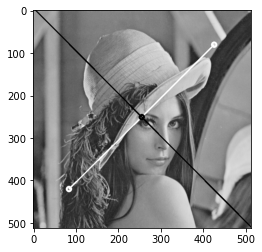

In [18]:
# visual
theta=ret_list[4]
xg=ret_list[5]
yg=ret_list[6]
rho = 800
dx_major = rho * np.cos(theta)
dy_major = rho * np.sin(theta)
dx_minor = 0.3 * rho * np.cos(theta - np.pi / 2)
dy_minor = 0.3 * rho * np.sin(theta - np.pi / 2)
# short
short_axis=[(int(xg-dx_minor),int(yg-dy_minor)),(int(xg),int(yg)),(int(xg+dx_minor),int(yg+dy_minor))]
for i in range(len(short_axis)-1):
    cv2.line(img,short_axis[i],short_axis[i+1],color=(255,0,0),thickness=2)
for pt in short_axis:
    cv2.circle(img,pt,radius=5,color=(255,0,0),thickness=3,lineType=-1)
# long
long_axis = [(int(xg - dx_major), int(yg - dy_major)), (int(xg), int(yg)), (int(xg + dx_major), int(yg + dy_major))]
for i in range(len(long_axis) - 1):
    cv2.line(img, long_axis[i], long_axis[i + 1], color=(0, 0, 255), thickness=2)
for pt in long_axis:
    cv2.circle(img,pt,radius=5,color=(0,0,255),thickness=3,lineType=-1)
# center
cv2.circle(img, (int(xg),int(yg)), radius=5, color=(0, 255, 0), thickness=3, lineType=-1)
# show
#cv2.imshow("img",img)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [19]:
# an=get_an(m00, m10,0.4)
# xn=an*xg
# yn=an*yg

# def get_Ls():

# n11=mu11/a
# n20=mu20/a
# n02=mu02/a

# r11=4*n11-xg*yg/2.0
# r22=r11

# r12=4*n20-xg**2/2.0
# r21=4*n20-yg**2/2.0

# r31=3*yg/2.0
# r32=3*xg/2.0

# delta = (mu20-mu02)**2+4*mu11**2
# awx=(5*(mu12*(mu20-mu02)+mu11*(mu03-mu21))+
#      xg*(mu02*(mu20-mu02)-2*mu11**2)+yg*mu11*(mu20+mu02))/delta
# awy=(5*(mu21*(mu02-mu20)+mu11*(mu30-mu12))+
#      yg*(mu20*(mu02-mu20)-2*mu11**2)+xg*mu11*(mu20+mu02))/delta

# lxn=np.array([-1.0,0.0,0.,an*r11,-an*(1+r12),yn])
# lyn=np.array([0,-1.0,0,an*(1+r21),-an*r22,-xn])
# lan=np.array([0,0,-1.0,-an*r31,an*r32,0])
# la=np.array([0,0,0,awx,awy,-1.0])
# lcx=np.array([0,0,0,1.0,0,0])
# lcy=np.array([0,0,0,0,1.0,0])

# Ls=np.array([lxn,lyn,lan,lcx,lcy,la])
# print(Ls)


In [20]:
# mx=1
# my=2
# s=np.array([xn,yn,an,mx,my,theta])
# s0=np.array([xn-1,yn+2,an,mx,my,theta+10])
# error=s-s0
# lamda=0.5
# Ls_inv=np.linalg.inv(Ls)

# vc=-lamda*Ls_inv@error
# vc

In [21]:
def get_vc(ret_lst):
    mx=1
    my=2
    Ls=ret_lst[0]
    xn=ret_lst[1]
    yn=ret_lst[2]
    an=ret_lst[3]
    theta=ret_lst[4]
    s=np.array([xn,yn,an,mx,my,theta],dtype=np.float32)
    s0=np.array([xn-1.00736274,yn+2,an,mx,my,theta+10],dtype=np.float32)
#     print("s,s0",s,s0)
    error=s-s0
    lamda=0.5
    Ls_inv=np.linalg.inv(Ls)

    vc=-lamda*Ls_inv@error
    
    return vc,error


In [22]:
def get_ejc():
    cte=np.array([-0.02895950536,-0.09892502277,0.0118580624])
    cre=np.array([[0.9999473971,-0.009749107311,-0.00318714031],
                 [0.00973491764,0.9999427672,-0.004437767002],
                 [0.003230222168,0.004406507014,0.9999850741]])

    s_cte=np.array([ [0,-cte[2],cte[1] ],
                   [cte[2],0,-cte[0] ],
                   [-cte[1],cte[0],0] ])
    ejc=np.zeros(shape=(6,6),dtype=np.float32)

    ejc[0:3,0:3]=cre
    ejc[0:3,3:6]=-cre@s_cte
    ejc[3:6,3:6]=cre
    return ejc

In [23]:
def main():
    
    ejc=get_ejc()
    
    if True:
#     while True:
        # img from rs2
        
        # moments
        
        ret_list=get_Ls(moments=moments)
        vc,error=get_vc(ret_list)
        
        e_norm=np.linalg.norm(error)
        print("e_norm: ",e_norm)
#         if e_norm<=0.1:
#             break
            
        ve=ejc@vc
        # ur5
if __name__=="__main__":
   main()

e_norm:  10.247672


In [24]:
class History:
    def __init__(self):
        self.v=np.array([.0,.0,.0,.0,.0,.0])
        self.e=np.array([.0,.0,.0,.0,.0,.0])
    
    def show_v(self):
        print(self.v)
            

In [25]:
h1=History()
h1.show_v()
h2=History()
h2.show_v()

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


In [26]:
list_history=[]

for i in range(6):
    h1=History()
    h1.v[i]=i
    list_history.append(h1)
# while e<0.01:

In [27]:
e_list=[]
v_list=[]

for h in list_history:
    e_list.append(h.e)
    v_list.append(h.v)


In [28]:
e_np=np.array(e_list)
v_np=np.array(v_list)

v_np[:,1]


array([0., 1., 0., 0., 0., 0.])

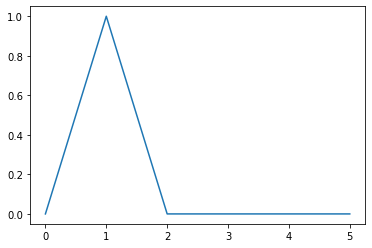

In [29]:
# plot
tx=np.linspace(0,len(list_history)-1,len(list_history))
ty=v_np[:,1]

plt.plot(tx,ty)

In [30]:
tx

array([0., 1., 2., 3., 4., 5.])

In [5]:
print(sklearn)

<module 'sklearn' from 'D:\\Anaconda3\\lib\\site-packages\\sklearn\\__init__.py'>
